In [1]:
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt

# notebook settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 1000)

## Sample Prep

In [2]:
samples = pd.read_csv('../data/TCGA/rna-seq_pan/meta/gdc_sample_sheet.2019-12-12.tsv', sep="\t")
# get file type
samples['data'] = [val[1] for i,val in samples['File Name'].str.split(".").items()]
samples['project'] = [val[1] for i,val in samples['Project ID'].str.split("-").items()]
samples['project'].value_counts()

BRCA    1206
LUAD     588
UCEC     567
KIRC     554
LUSC     543
LGG      524
PRAD     517
COAD     506
THCA     505
SKCM     469
BLCA     431
LIHC     421
STAD     402
OV       379
KIRP     308
CESC     306
ESCA     171
PAAD     171
GBM      166
TGCT     150
PCPG     133
LAML     123
KICH      81
ACC       75
CHOL      41
SARC      10
DLBC       9
READ       7
MESO       1
Name: project, dtype: int64

In [3]:
samples['Sample Type'].value_counts()

Primary Tumor                                      8166
Solid Tissue Normal                                 636
Metastatic                                          385
Primary Blood Derived Cancer - Peripheral Blood     123
Recurrent Tumor                                      43
Additional - New Primary                             10
Additional Metastatic                                 1
Name: Sample Type, dtype: int64

In [9]:
samples.shape
cases = samples[samples['Sample Type']=='Primary Tumor'].sample(frac=1).copy()
cases.shape
proj = cases['project'].value_counts().head(10).index
cases = cases[cases['project'].isin(proj)]
cases['project'].value_counts()
cases.shape

(9364, 10)

(8166, 10)

BRCA    1087
UCEC     544
LUAD     528
LGG      506
LUSC     496
KIRC     483
PRAD     466
COAD     465
THCA     445
BLCA     412
Name: project, dtype: int64

(5432, 10)

## Dataset Prep

In [10]:
from sklearn.model_selection import train_test_split

target = 'project'
cases[target] = cases[target].astype('category')
train, test = train_test_split(cases)

In [11]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import visualization as vis
import numpy as np

if torch.cuda.is_available():
    cuda = torch.cuda.is_available()
    print("{} GPUs available".format(torch.cuda.device_count()))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
classes = train[target].cat.categories.values


8 GPUs available


In [12]:
from tcga_datasets import TCGA, SiameseTCGA
root_dir = "../data/TCGA/rna-seq_pan/"
batch_size = 1

train_dataset = TCGA(root_dir, samples=train, train=True, target=target)
test_dataset = TCGA(root_dir, samples=test, train=False, target=target)
print('Loaded')
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

Loaded


## Siamese Network

In [13]:
# Step 1 set up dataloader
siamese_train_dataset = SiameseTCGA(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseTCGA(test_dataset)
batch_size = 64
kwargs = {'num_workers': 10, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from tcga_networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
from metrics import AccumulatedAccuracyMetric

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model = nn.DataParallel(model)
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 10
# print training metrics every log_interval * batch_size
log_interval = 4

DataParallel(
  (module): SiameseNet(
    (embedding_net): EmbeddingNet(
      (fc): Sequential(
        (0): Linear(in_features=60483, out_features=2000, bias=True)
        (1): PReLU(num_parameters=1)
        (2): Linear(in_features=2000, out_features=500, bias=True)
        (3): PReLU(num_parameters=1)
        (4): Linear(in_features=500, out_features=250, bias=True)
        (5): PReLU(num_parameters=1)
        (6): Linear(in_features=250, out_features=100, bias=True)
        (7): PReLU(num_parameters=1)
        (8): Linear(in_features=100, out_features=50, bias=True)
        (9): PReLU(num_parameters=1)
        (10): Linear(in_features=50, out_features=10, bias=True)
        (11): PReLU(num_parameters=1)
        (12): Linear(in_features=10, out_features=2, bias=True)
      )
    )
  )
)

In [14]:
train_loss, val_loss = fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, 
    n_epochs, cuda, log_interval)

Train: [0/4074 (0%)]	Loss: 0.262692
Train: [256/4074 (6%)]	Loss: 4.697056
Train: [512/4074 (12%)]	Loss: 0.960701
Train: [768/4074 (19%)]	Loss: 2.739669
Train: [1024/4074 (25%)]	Loss: 0.893237
Train: [1280/4074 (31%)]	Loss: 2.260341
Train: [1536/4074 (38%)]	Loss: 0.619737
Train: [1792/4074 (44%)]	Loss: 0.511726
Train: [2048/4074 (50%)]	Loss: 0.434056
Train: [2304/4074 (56%)]	Loss: 0.205737
Train: [2560/4074 (62%)]	Loss: 0.224834
Train: [2816/4074 (69%)]	Loss: 0.165997
Train: [3072/4074 (75%)]	Loss: 0.097918
Train: [3328/4074 (81%)]	Loss: 0.158752
Train: [3584/4074 (88%)]	Loss: 0.116707
Train: [3840/4074 (94%)]	Loss: 0.193258
Epoch: 1/10. Train set: Average loss: 0.9028
Epoch: 1/10. Validation set: Average loss: 0.1402
Train: [0/4074 (0%)]	Loss: 0.158404
Train: [256/4074 (6%)]	Loss: 0.107966
Train: [512/4074 (12%)]	Loss: 0.221601
Train: [768/4074 (19%)]	Loss: 0.238340
Train: [1024/4074 (25%)]	Loss: 0.183364
Train: [1280/4074 (31%)]	Loss: 0.114250
Train: [1536/4074 (38%)]	Loss: 0.114264
T

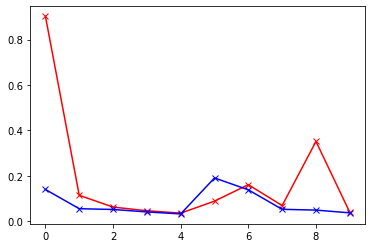

In [15]:
plt.plot(range(0, n_epochs), train_loss, 'rx-')
plt.plot(range(0, n_epochs), val_loss, 'bx-')

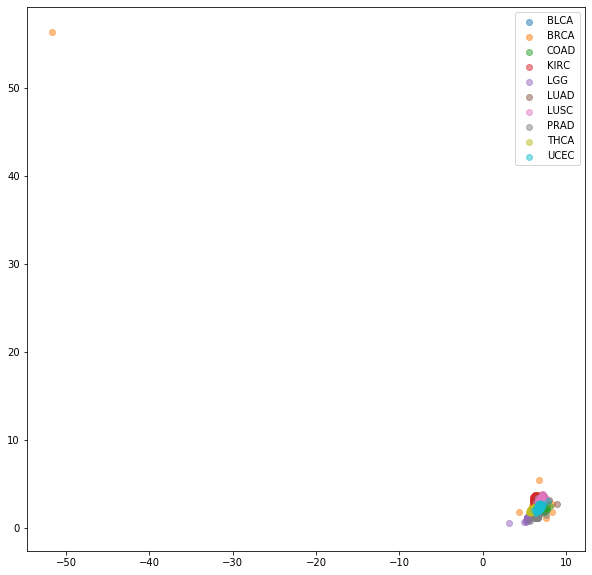

In [16]:
train_embeddings_cl, train_labels_cl = vis.extract_embeddings(train_loader, model)
vis.plot_embeddings(train_embeddings_cl, train_labels_cl, classes)

3488   -51.646923
3324     3.119873
1828     4.313900
131      4.961632
1912     5.135724
          ...    
3576     7.897088
1472     8.029236
3182     8.332161
897      8.346626
1849     8.866341
Name: 0, Length: 4074, dtype: float64

3324    3.119873
1828    4.313900
131     4.961632
1912    5.135724
1316    5.249924
          ...   
3576    7.897088
1472    8.029236
3182    8.332161
897     8.346626
1849    8.866341
Name: 0, Length: 4073, dtype: float64

7.0

7.0

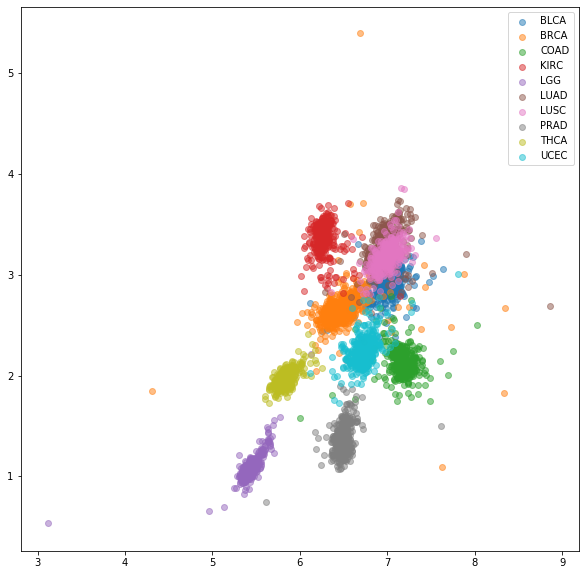

In [46]:
train_embeddings_df = pd.DataFrame(train_embeddings_cl)
train_labels_tmp = train_labels_cl
train_embeddings_df[0].sort_values()
train_embeddings_df = train_embeddings_df.drop(3488)
train_embeddings_df[0].sort_values()
train_labels_tmp = np.delete(train_labels_tmp, 3488)
vis.plot_embeddings(train_embeddings_df.values, train_labels_tmp, classes)

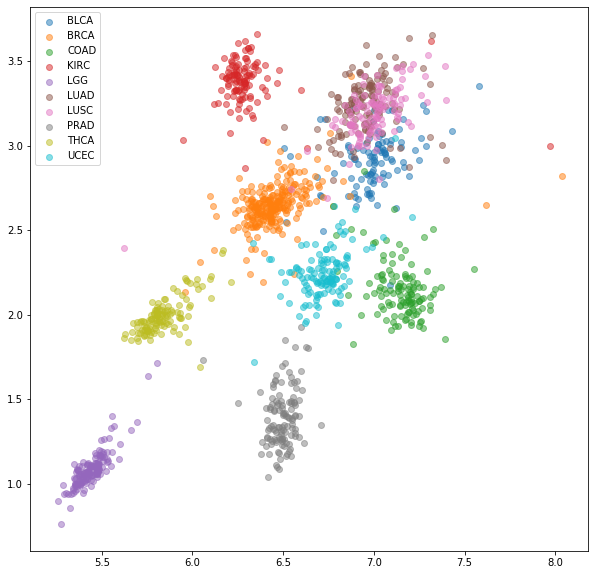

In [47]:
val_embeddings_baseline, val_labels_baseline = vis.extract_embeddings(test_loader, model)
vis.plot_embeddings(val_embeddings_baseline, val_labels_baseline, classes)

In [53]:
train_dataset[3488]

(tensor([0.0000, 0.0000, 1.0134,  ..., 0.0000, 0.2163, 0.0000]), 7)

In [54]:
classes

array(['BLCA', 'BRCA', 'COAD', 'KIRC', 'LGG', 'LUAD', 'LUSC', 'PRAD',
       'THCA', 'UCEC'], dtype=object)